In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import json


config = json.load(open('../config.json'))
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [2]:
existing_studies = vis2D.existing_studies_df()

[(0.0, 10.0), (0.0, 3.0)]

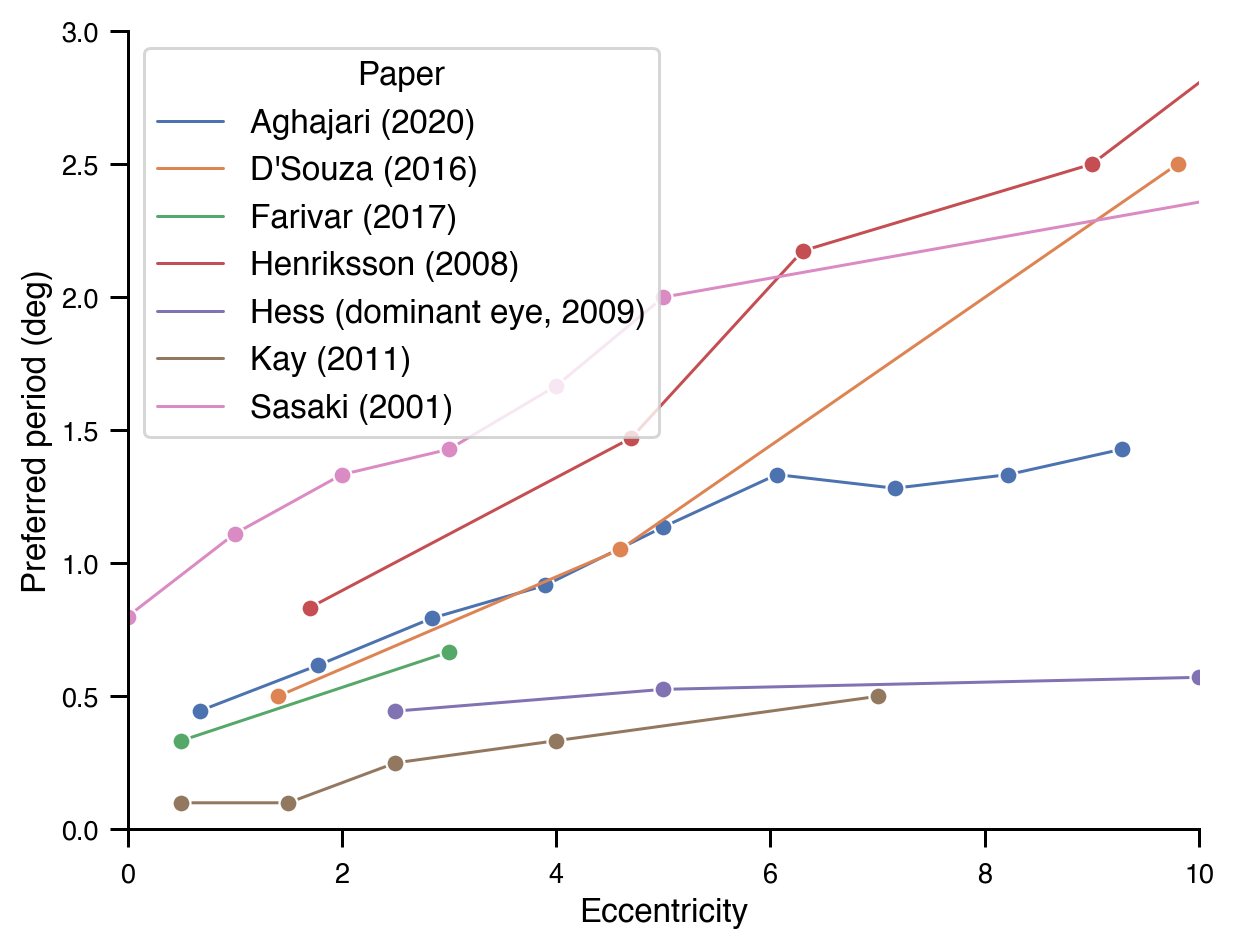

In [121]:
ax = sns.lineplot(existing_studies, x='Eccentricity', y='Preferred period (deg)', hue='Paper', marker='o')
ax.set(xlim=(0,10), ylim=(0,3))

In [3]:
# For each study, fit a line to Preferred period (deg) as a function of Eccentricity
fit_df = vis2D.fit_study_lines(existing_studies)


In [4]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
results_dir = os.path.join(output_dir, 'sfp_model', 'results_2D')
fig_dir = os.path.join(output_dir, 'figures')
lr = 0.0005
max_epoch = 30000
roi_list = ['V1']
vsc='pRFsize'
nsd_subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]
ARGS_2D = ['sub','lr','eph','roi']
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in  [3,2,0]]
roi_pal.insert(0, (0.3,0.3,0.3))
stim_classes=['annulus', 'pinwheel', 'forward spiral','reverse spiral']
goal='replication'

pt_file_list = []
for subj, roi in itertools.product(nsd_subj_list, ['V1']):
    file_name = os.path.join(output_dir, 'sfp_model', 'results_2D', 'nsdsyn', 'corrected',
                             f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
nsd_params = model.load_all_models(pt_file_list, *ARGS_2D)

nsd_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision',f'precision-s_dset-nsdsyn_vs-pRFsize.csv'))
nsd_df = pd.merge(nsd_params, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])
pt_file_list = []
for subj, roi in itertools.product(broderick_subj_list, ['V1']):
    file_name = os.path.join(output_dir,'sfp_model', 'results_2D', 'broderick','corrected', f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(file_name)
broderick_params = model.load_all_models(pt_file_list, *ARGS_2D)

broderick_precision_s =  pd.read_csv(os.path.join(output_dir, 'dataframes', 'broderick', 'precision','corrected', f'precision-s_dset-broderick_vs-pRFsize.csv'))
broderick_df = pd.merge(broderick_params, broderick_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

broderick_df['dset_type'] = 'Broderick et al. V1'
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')
final_params = pd.concat((broderick_df, nsd_df), axis=0)

In [5]:
pt_file_list = []
ecc_1, ecc_2, n_ecc = 0, 12, 121
angle_1, angle_2, n_angle = 0, 360, 361
for subj, roi, frame in itertools.product(nsd_subj_list, ['V1'], ['scaled']):
    file_name = os.path.join(output_dir, 'sfp_model', 'prediction_2D', 'nsdsyn', 'corrected',
                             f'sfstimuli-{frame}_eccentricity-{ecc_1}-{ecc_2}-{n_ecc}_angle-{angle_1}-{angle_2}-{n_angle}_lr-0.0005_eph-30000_sub-{subj}_roi-{roi}_vs-pRFsize.h5')
    pt_file_list.append(file_name)
nsd_prediction = utils.load_dataframes(pt_file_list, *ARGS_2D+['sfstimuli'])

nsd_df = pd.merge(nsd_prediction, nsd_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

pt_file_list = []
ecc_1, ecc_2, n_ecc = 0, 12, 121
angle_1, angle_2, n_angle = 0, 360, 361
for subj, roi, frame in itertools.product(broderick_subj_list, ['V1'], ['scaled']):
    file_name = os.path.join(output_dir,  'sfp_model', 'prediction_2D', 'broderick', 'corrected',
                             f'sfstimuli-{frame}_eccentricity-{ecc_1}-{ecc_2}-{n_ecc}_angle-{angle_1}-{angle_2}-{n_angle}_lr-0.0005_eph-30000_sub-{subj}_roi-{roi}_vs-pRFsize.h5')
    pt_file_list.append(file_name)
broderick_prediction = utils.load_dataframes(pt_file_list, *ARGS_2D+['sfstimuli'])

broderick_df = pd.merge(broderick_prediction, broderick_precision_s[['sub','vroinames','precision']], on=['sub','vroinames'])

broderick_df['dset_type'] = 'Broderick et al. V1'
nsd_df['dset_type'] = nsd_df['vroinames'].apply(lambda x: f'NSD {x}')
final_df = pd.concat((broderick_df, nsd_df), axis=0)

In [6]:
ecc_list=[0,10]
ecc_df = final_df.query('sfstimuli == "scaled" & eccentricity in @ecc_list')
ecc_df = ecc_df.groupby(['sub','dset_type','vroinames','eccentricity']).mean().reset_index()
merged_df = pd.merge(existing_studies, fit_df, on='Paper')


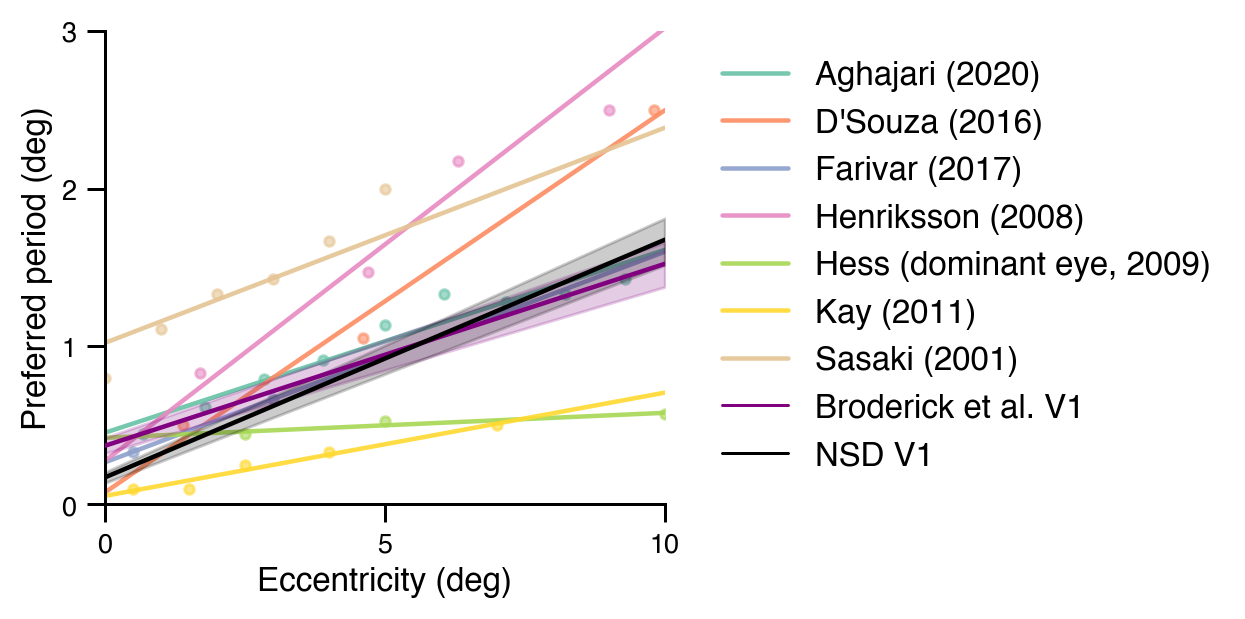

In [81]:
merged_df = pd.merge(existing_studies, fit_df, on='Paper')
fig, ax = vis2D.plot_preferred_period_vs_eccentricity_for_existing_studies(merged_df, ecc_df)


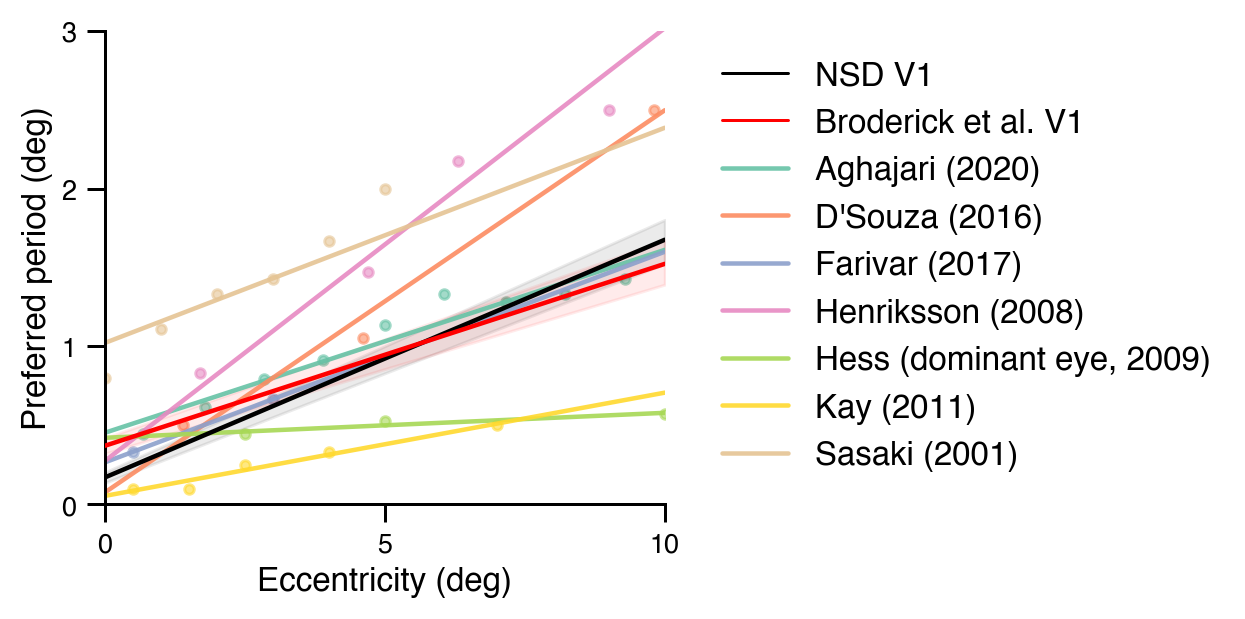

In [125]:
fig, ax = vis2D.plot_preferred_period_vs_eccentricity_for_existing_studies(merged_df, ecc_df)

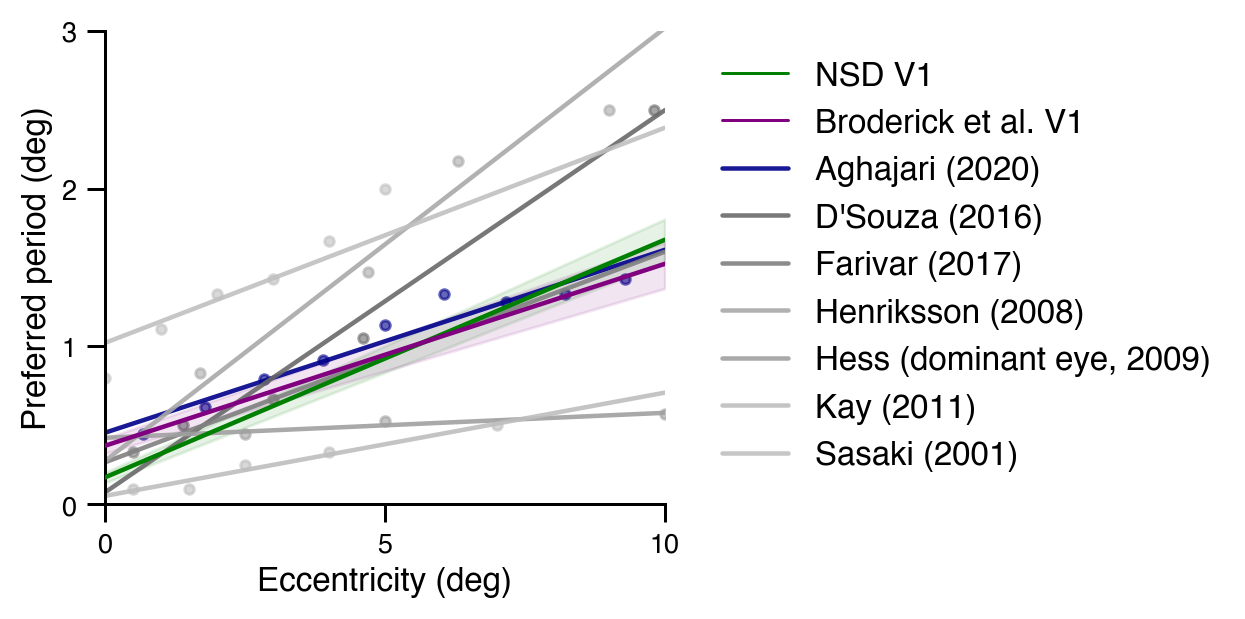

In [ ]:
#all gray except for NSD, Broderick, aghajari (differnt shades)
#labels next to each line
#reduce alpha for ci

fig, ax = vis2D.plot_preferred_period_vs_eccentricity_for_existing_studies(merged_df, ecc_df)



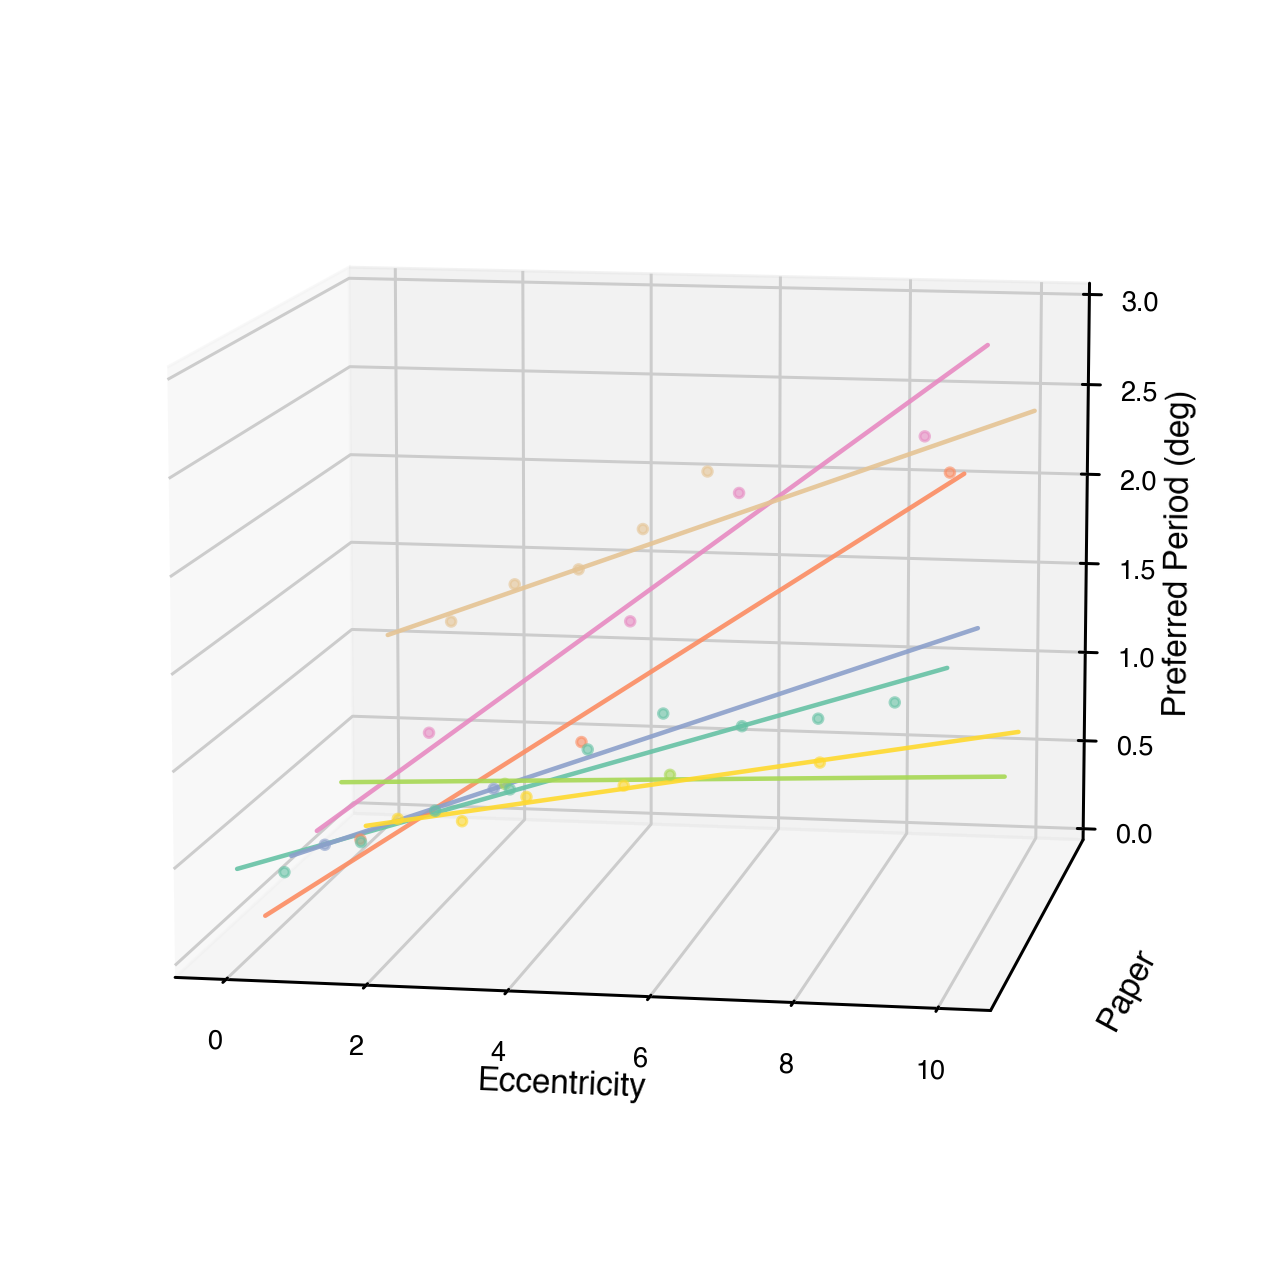

In [149]:
# or 3d plot?
fig, ax = vis2D.plot_3d_preferred_period_vs_eccentricity_for_existing_studies(merged_df, ecc_df)



In [89]:
preferred_period_df = vis2D.calculate_preferred_period_at_eccentricity(fit_df, eccentricity=10)


Paper                               Sasaki (2001)
Preferred period at eccentricity         3.016381
dtype: object

In [8]:
existing_studies.Paper.unique()

array(['Aghajari (2020)', "D'Souza (2016)", 'Farivar (2017)',
       'Henriksson (2008)', 'Hess (dominant eye, 2009)', 'Kay (2011)',
       'Sasaki (2001)'], dtype=object)

In [11]:
merged_df
similar_studies = ['Aghajari (2020)', 'Farivar (2017)']
nonsimilar_studies = [k for k in existing_studies.Paper.unique() if k not in similar_studies]

nonsimilar_studies

["D'Souza (2016)",
 'Henriksson (2008)',
 'Hess (dominant eye, 2009)',
 'Kay (2011)',
 'Sasaki (2001)']

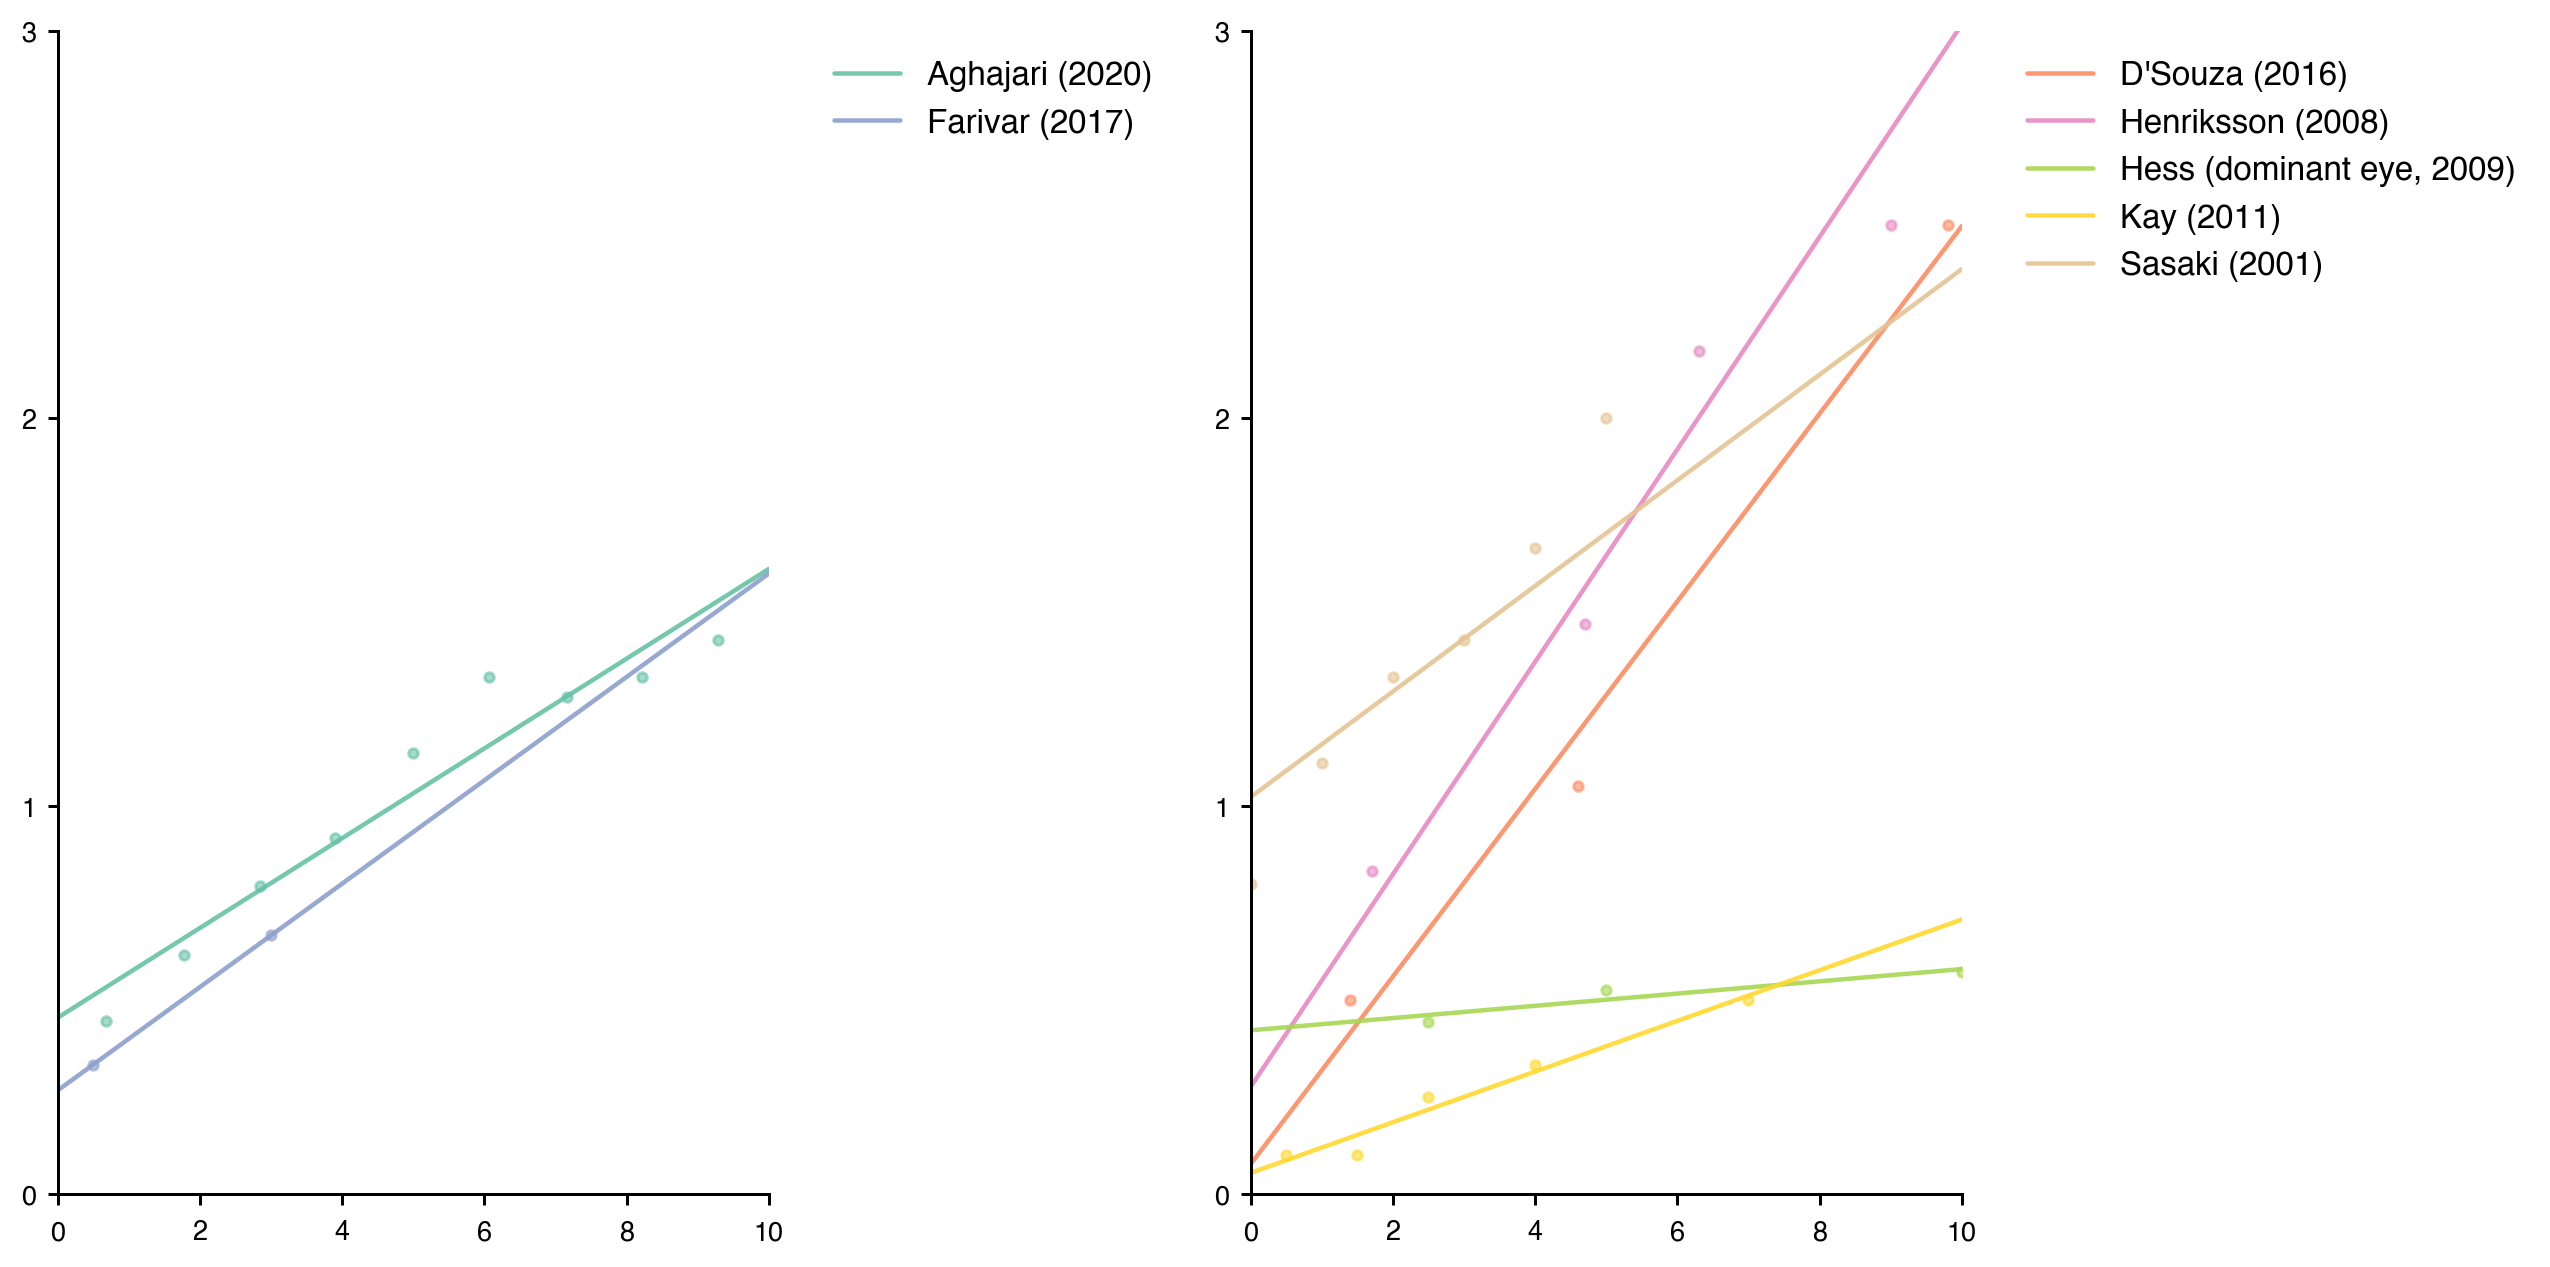

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0] = vis2D.plot_preferred_period_vs_eccentricity_for_existing_studies(merged_df.query('Paper in @similar_studies'), None, ax=axes[0])
axes[1] = vis2D.plot_preferred_period_vs_eccentricity_for_existing_studies(merged_df.query('Paper in @nonsimilar_studies'), None, ax=axes[1])
plt.show()


In [ ]:

# subplots, seprately but with the same reference (our study)
# bar graphs (for two points)